# Analisi e Filtri sui Goal

Questo notebook mostra come caricare i dati dei match dal database e applicare filtri basati sui goal segnati.
Nota: Per analizzare i risultati del primo tempo, assicurati di aver aggiornato il database con le colonne `home_score_ht` e `away_score_ht`.

In [153]:
import sys
import os
import pandas as pd
import psycopg2
import requests
import importlib
import warnings
warnings.filterwarnings('ignore')

# Aggiungiamo la root del progetto al path per importare i moduli
from modules.config import DB_CONFIG
import modules.analysis
importlib.reload(modules.analysis)
from modules.analysis import get_matches, get_stats_by_period, get_matches_by_partial_score, get_matches_by_ht_score, get_len_table

# Carichiamo i dati iniziali
df = get_matches()

In [154]:
# Preprocessing dei dati
# Convertiamo i punteggi in numeri (gestendo eventuali 'N/A' o errori)
df['home_score'] = pd.to_numeric(df['home_score'], errors='coerce')
df['away_score'] = pd.to_numeric(df['away_score'], errors='coerce')

# HT Scores (potrebbero essere NaN per vecchi match)
df['home_score_ht'] = pd.to_numeric(df['home_score_ht'], errors='coerce')
df['away_score_ht'] = pd.to_numeric(df['away_score_ht'], errors='coerce')

# Rimuoviamo righe dove i punteggi finali sono NaN
df = df.dropna(subset=['home_score', 'away_score'])

# Calcoliamo i goal totali
df['total_goals'] = df['home_score'] + df['away_score']

df.head()

,id,home_team,away_team,home_score,away_score,home_score_ht,away_score_ht,tournament,start_timestamp,total_goals
0,12436498,Chelsea,Aston Villa,3.0,0.0,NaN,NaN,Premier League,1733059800,3.0
1,12436505,Manchester United,Everton,4.0,0.0,NaN,NaN,Premier League,1733059800,4.0
2,12436507,Tottenham Hotspur,Fulham,1.0,1.0,NaN,NaN,Premier League,1733059800,2.0
3,12436504,Liverpool,Manchester City,2.0,0.0,NaN,NaN,Premier League,1733068800,2.0
4,12504665,Udinese,Genoa,0.0,2.0,NaN,NaN,Serie A,1733052600,2.0


## Esempio di Filtro per Goal

Qui sotto mostriamo come filtrare il DataFrame per trovare i match che soddisfano determinati criteri di punteggio.

In [155]:
# ESEMPIO 1: Filtro per "Over 2.5" (più di 2 goal totali)
over_25_matches = df[df['total_goals'] > 2.5]

# ESEMPIO 2: Filtro per "Goal/Goal" (entrambe le squadre segnano)
goal_goal_matches = df[(df['home_score'] > 0) & (df['away_score'] > 0)]

# ESEMPIO 3: Filtro combinato (Over 2.5 AND Goal/Goal)
combined_filter = df[(df['total_goals'] > 2.5) & (df['home_score'] > 0) & (df['away_score'] > 0)]

print(f"Totale match validi: {len(df)}")
print(f"Match Over 2.5: {len(over_25_matches)} ({len(over_25_matches)/len(df)*100:.1f}%)")
print(f"Match Goal/Goal: {len(goal_goal_matches)} ({len(goal_goal_matches)/len(df)*100:.1f}%)")

Totale match validi: 12175
Match Over 2.5: 6137 (50.4%)
Match Goal/Goal: 6257 (51.4%)


## Funzioni di Utility per Statistiche Avanzate

## Analisi Primo Tempo (Basata su Statistiche)

Utilizziamo la tabella `match_statistics_column` per trovare partite con caratteristiche specifiche al primo tempo (es. 0 tiri in porta), superando il limite dei dati mancanti nel DB principale.

## Analisi Avanzata xG HT

In questa sezione analizziamo la pericolosità (xG) del primo tempo indipendentemente dal punteggio.

In [156]:
#Record con xG != null


Caricamento dati in corso...

Recupero statistiche xG per il primo tempo...
--- ANALISI PER PUNTEGGIO HT: 1-1 ---
Match trovati con dati xG: 189



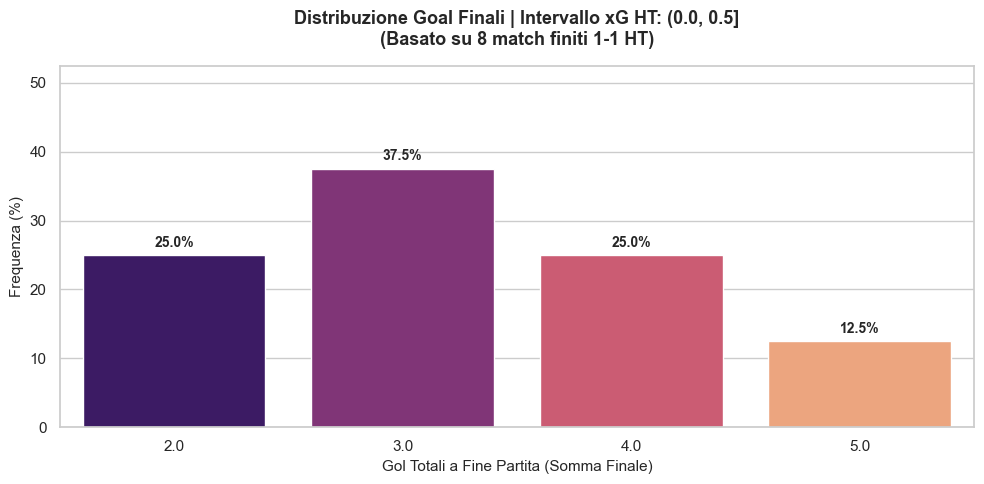

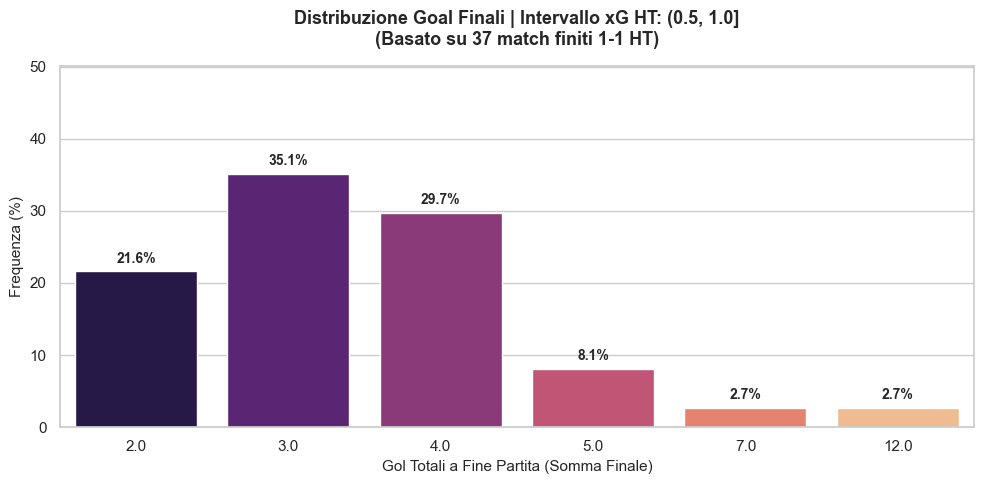

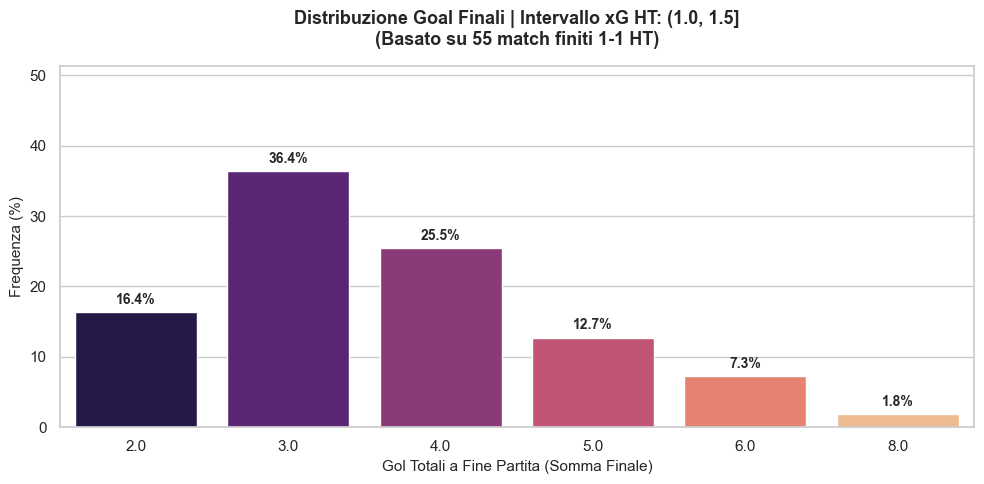

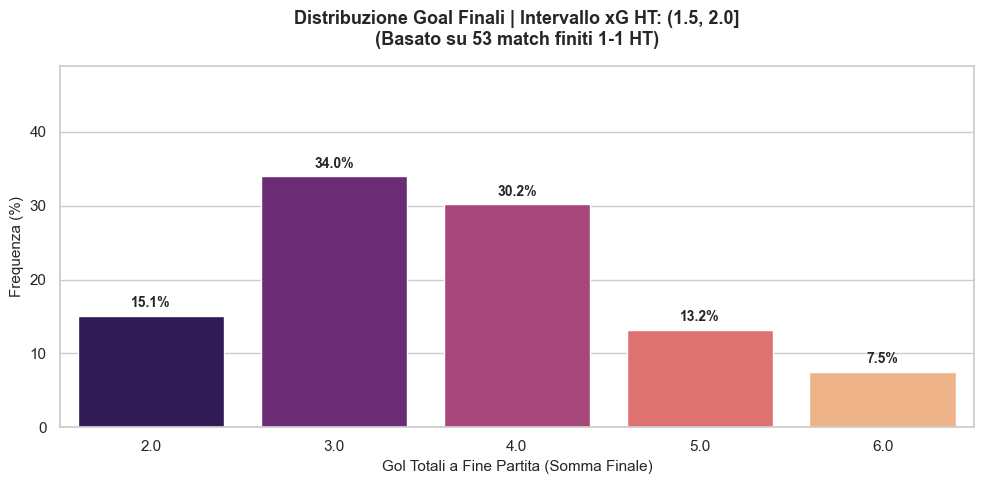

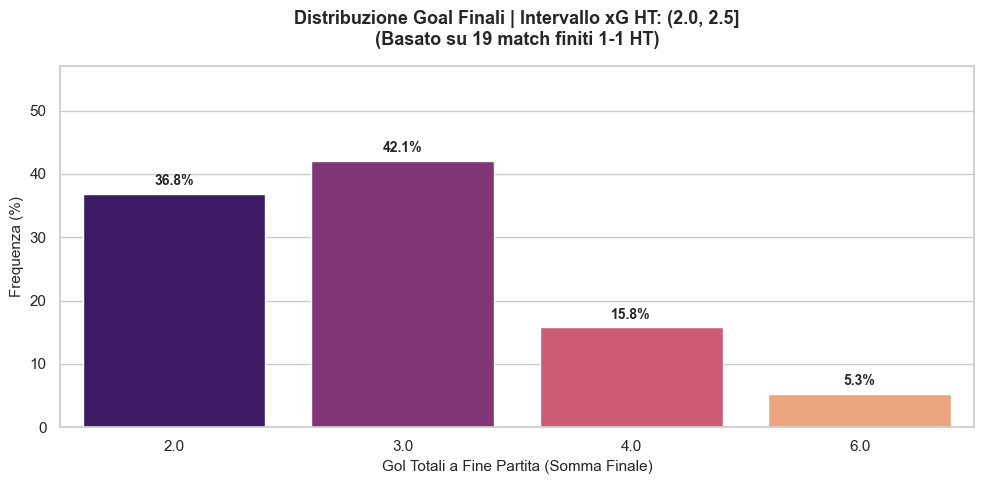

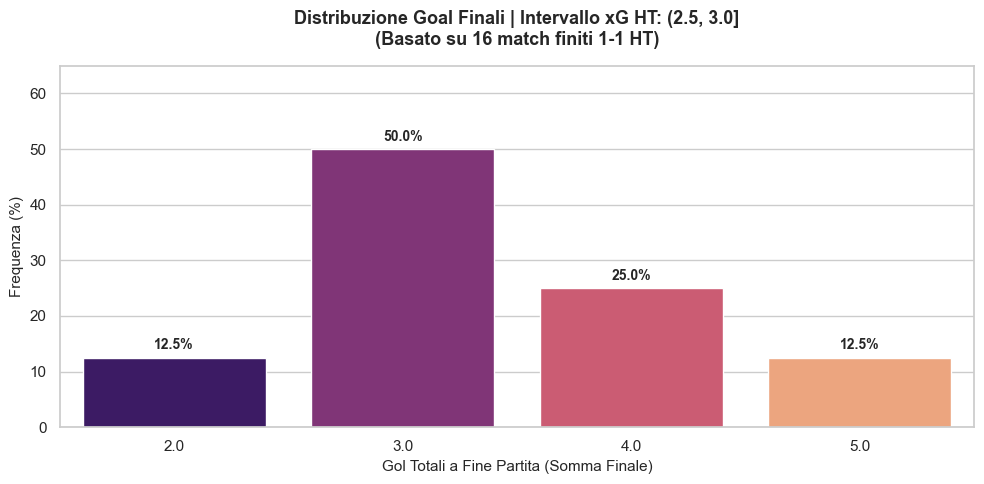

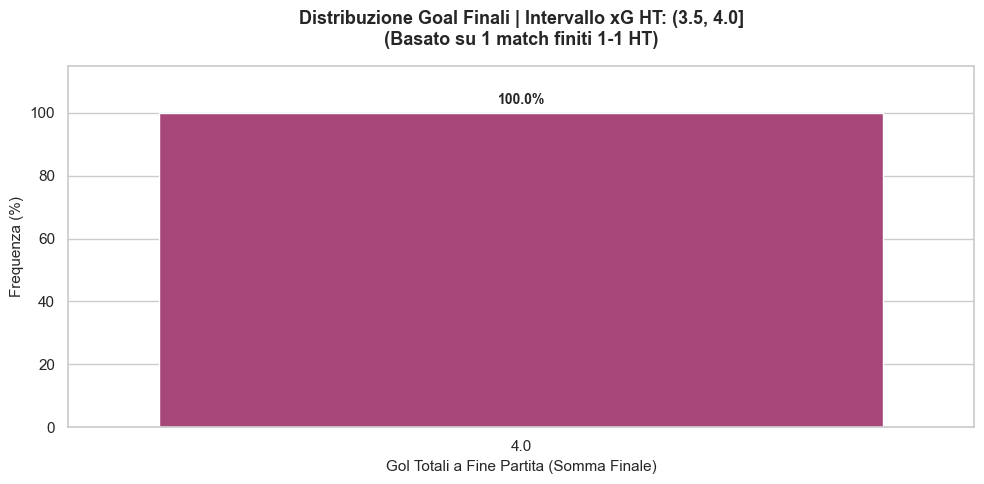


=== TABELLA RIASSUNTIVA RENDIMENTI ===
Risultato HT analizzato: 1-1


,num_match,media_goal_finali,pct_over_1_5,pct_over_2_5
xg_interval,,,,
"(0.0, 0.5]",8,3.25,100.0,75.00
"(0.5, 1.0]",37,3.59,100.0,78.38
"(1.0, 1.5]",55,3.65,100.0,83.64
"(1.5, 2.0]",53,3.64,100.0,84.91
"(2.0, 2.5]",19,2.95,100.0,63.16
"(2.5, 3.0]",16,3.38,100.0,87.50
"(3.5, 4.0]",1,4.00,100.0,100.00


In [157]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import warnings

# Configurazione ambiente e moduli
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

# Import dei moduli personalizzati
from modules.config import DB_CONFIG
import modules.analysis
importlib.reload(modules.analysis)
from modules.analysis import get_matches, get_stats_by_period
from modules.report_utils import PdfReport

# --- 1. CARICAMENTO E PREPROCESSING DATI ---
print("Caricamento dati in corso...")
df = get_matches()

# Pulizia e conversione tipi
df['home_score'] = pd.to_numeric(df['home_score'], errors='coerce')
df['away_score'] = pd.to_numeric(df['away_score'], errors='coerce')
df['home_score_ht'] = pd.to_numeric(df['home_score_ht'], errors='coerce')
df['away_score_ht'] = pd.to_numeric(df['away_score_ht'], errors='coerce')

# Rimuoviamo righe corrotte e calcoliamo i goal totali finali
df = df.dropna(subset=['home_score', 'away_score'])
df['total_goals'] = df['home_score'] + df['away_score']

# --- 2. ANALISI AVANZATA xG E INTERVALLI ---
try:
    # CONFIGURAZIONE FILTRI
    target_home_ht = 1    # Risultato casa HT (0 = 0-0 se entrambi a 0)
    target_away_ht = 1    # Risultato trasferta HT
    interval_step = 0.5   # Ampiezza intervalli xG (es. ogni 0.5 xG)
    SAVE_TO_PDF = True    # Flag per salvataggio PDF

    if SAVE_TO_PDF:
        report = PdfReport('graphics/xg_distribution_report.pdf')

    print(f"\nRecupero statistiche xG per il primo tempo...")
    df_xg_ht = get_stats_by_period(['Expected goals'], period='1ST')
    
    # Unione con i dati dei match
    df_advanced = df.merge(df_xg_ht, left_on='id', right_on='match_id', how='inner')
    
    # Calcolo xG totale prodotto nel primo tempo
    if 'expected_goals_homevalue' in df_advanced.columns:
        df_advanced['total_xg_ht'] = df_advanced['expected_goals_homevalue'] + df_advanced['expected_goals_awayvalue']
    else:
        df_advanced['total_xg_ht'] = 0
    
    # Filtro specifico per il punteggio HT desiderato (0-0)
    ht_matches = df_advanced[
        (df_advanced['home_score_ht'] == target_home_ht) & 
        (df_advanced['away_score_ht'] == target_away_ht)
    ].copy()

    print(f"--- ANALISI PER PUNTEGGIO HT: {target_home_ht}-{target_away_ht} ---")
    print(f"Match trovati con dati xG: {len(ht_matches)}\n")

    if not ht_matches.empty:
        # CREAZIONE INTERVALLI DINAMICI
        max_xg = ht_matches['total_xg_ht'].max()
        # Creiamo i "bins" (limiti degli intervalli) dal valore 0 al massimo raggiunto
        bins = np.arange(0, max_xg + interval_step, interval_step)
        if bins[-1] < max_xg: 
            bins = np.append(bins, bins[-1] + interval_step)
        
        # Assegniamo ogni match al proprio intervallo xG
        ht_matches['xg_interval'] = pd.cut(ht_matches['total_xg_ht'], bins=bins)

        # GENERAZIONE GRAFICI
        active_intervals = sorted(ht_matches['xg_interval'].dropna().unique())
        
        for interval in active_intervals:
            subset = ht_matches[ht_matches['xg_interval'] == interval]
            total_in_interval = len(subset)
            
            if total_in_interval == 0: continue

            # Calcolo frequenza gol totali a fine partita
            # Normalizziamo per ottenere la percentuale relativa all'intervallo
            goal_counts = subset['total_goals'].value_counts(normalize=True).sort_index() * 100
            
            plt.figure(figsize=(10, 5))
            ax = sns.barplot(x=goal_counts.index, y=goal_counts.values, palette="magma")
            
            # Estetica del grafico
            plt.title(f"Distribuzione Goal Finali | Intervallo xG HT: {interval}\n"
                      f"(Basato su {total_in_interval} match finiti {target_home_ht}-{target_away_ht} HT)", 
                      fontsize=13, fontweight='bold', pad=15)
            plt.xlabel("Gol Totali a Fine Partita (Somma Finale)", fontsize=11)
            plt.ylabel("Frequenza (%)", fontsize=11)
            plt.ylim(0, max(goal_counts.values) + 15) # Spazio per i numeri sopra le barre
            
            # Aggiungiamo le percentuali su ogni barra
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.1f}%', 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='center', xytext=(0, 9), 
                            textcoords='offset points', fontsize=10, fontweight='bold')

            plt.tight_layout()
            if SAVE_TO_PDF: report.add_current_plot()
            plt.show()
            
        if SAVE_TO_PDF: report.close()

        # TABELLA RIASSUNTIVA FINALE
        res_summary = ht_matches.groupby('xg_interval').agg(
            num_match=('id', 'count'),
            media_goal_finali=('total_goals', 'mean'),
            pct_over_1_5=('total_goals', lambda x: (x >= 1.5).mean() * 100),
            pct_over_2_5=('total_goals', lambda x: (x >= 2.5).mean() * 100)
        ).round(2)
        
        print("\n=== TABELLA RIASSUNTIVA RENDIMENTI ===")
        print(f"Risultato HT analizzato: {target_home_ht}-{target_away_ht}")
        display(res_summary)
        
    else:
        print(f"Attenzione: Non ci sono match nel database con risultato HT {target_home_ht}-{target_away_ht} dotati di statistiche xG.")

except Exception as e:
    print(f"Errore durante l'esecuzione dell'analisi: {e}")
    import traceback
    traceback.print_exc()

In [158]:
try:
    # Carichiamo xG del primo tempo
    df_xg_ht = get_stats_by_period(['Expected goals'], period='1ST')
    
    # Uniamo al dataframe principale
    df_advanced = df.merge(df_xg_ht, left_on='id', right_on='match_id', how='inner')
    
    # Calcoliamo xG totale del primo tempo
    if 'expected_goals_homevalue' in df_advanced.columns:
        df_advanced['total_xg_ht'] = df_advanced['expected_goals_homevalue'] + df_advanced['expected_goals_awayvalue']
    
    print(f"Match con statistiche xG caricate: {len(df_advanced)}")
    
    # ANALISI: Partite con xG HT totale > 1.2
    pericolose_ht = df_advanced[df_advanced['total_xg_ht'] > 1.2]
    
    print(f"Partite con xG HT totale > 1.2: {len(pericolose_ht)}")
    if not pericolose_ht.empty:
        display(pericolose_ht[['home_team', 'away_team', 'total_xg_ht', 'home_score', 'away_score', 'total_goals']])
        
        # Statistica: quante di queste finiscono con almeno 2 goal totali?
        over15 = len(pericolose_ht[pericolose_ht['total_goals'] >= 1.5])
        print(f"\nPercentuale Over 1.5 finale per queste partite: {over15/len(pericolose_ht)*100:.1f}%")
except Exception as e:
    print(f"Errore: {e}")

Match con statistiche xG caricate: 1890
Partite con xG HT totale > 1.2: 858


,home_team,away_team,total_xg_ht,home_score,away_score,total_goals
0,Chelsea,Aston Villa,1.67,3.0,0.0,3.0
2,Tottenham Hotspur,Fulham,1.24,1.0,1.0,2.0
3,Liverpool,Manchester City,1.83,2.0,0.0,2.0
4,Udinese,Genoa,1.47,0.0,2.0,2.0
7,Lecce,Juventus,1.21,1.0,1.0,2.0
...,...,...,...,...,...,...
1873,Pafos FC,Djurgårdens IF,1.45,1.0,0.0,1.0
1879,Junior Barranquilla,América de Cali,1.61,5.0,6.0,11.0
1882,Toulouse,AS Monaco,2.08,1.0,1.0,2.0
1885,Bodrum FK,Kasımpaşa,1.24,1.0,0.0,1.0



Percentuale Over 1.5 finale per queste partite: 86.0%


## Ricerca Match per Risultato Primo Tempo (HT)

Utilizziamo le colonne `home_score_ht` e `away_score_ht` della tabella `matches` per trovare rapidamente i risultati a fine primo tempo.

In [159]:
# ESEMPIO: Partite che erano sull'1-0 al termine del primo tempo
HT_HOME = 0
HT_AWAY = 0

print(f"Ricerca match con punteggio HT {HT_HOME}-{HT_AWAY}...")
res_ht = get_matches_by_ht_score(HT_HOME, HT_AWAY)
len_table = get_len_table("matches")

if not res_ht.empty:
    print(f"Trovati {len(res_ht)} match su {len_table} totali. ({len(res_ht)/len_table*100:.2f}%)")
    display(res_ht.head(20))
else:
    print("Nessun match trovato con questo punteggio HT.")

Ricerca match con punteggio HT 0-0...
Trovati 3635 match su 12685 totali. (28.66%)


,id,home_team,away_team,home_score_ht,away_score_ht,final_h,final_a
0,14058091,Egypt,Nigeria,0,0,2,4
1,14058089,Senegal,Morocco,0,0,1,0
2,14025079,Manchester United,Manchester City,0,0,2,0
3,14025073,Leeds United,Fulham,0,0,1,0
4,14025082,Nottingham Forest,Arsenal,0,0,0,0
5,14025092,Wolverhampton,Newcastle United,0,0,0,0
6,14025064,Aston Villa,Everton,0,0,0,1
7,13981625,Cagliari,Juventus,0,0,1,0
8,13981627,Parma,Genoa,0,0,0,0
9,13981628,Milan,Lecce,0,0,1,0


### Filtro Avanzato: Match con Pochi Tiri nel Primo Tempo

Analizziamo quali tra i match trovati sopra avevano un numero di tiri totali (Home + Away) compreso tra 0 e 5 nel primo tempo.

In [160]:
STAMPA_PARTITE = False
TIPO_STATISTICA = "Shots on target" # "Total shots", "Shots on target", "Hit woodwork", "Shots off target", "Blocked shots", "Shots inside box", "Shots outside box"

# Range
RANGE_1 = [0, 5]
RANGE_2 = [5, 10]
RANGE_3 = [10, 15]

try:
    # 1. Recuperiamo la statistica scelta
    df_stats_ht = get_stats_by_period([TIPO_STATISTICA], period='1ST')
    if df_stats_ht.empty: 
        print(f"Nessun dato per {TIPO_STATISTICA}")
        
    # Pulizia nomi colonne dinamica
    stat_clean = TIPO_STATISTICA.lower().replace(' ', '_')
    stat_col_h = f"{stat_clean}_homevalue"
    stat_col_a = f"{stat_clean}_awayvalue"
    
    # 2. Uniamo con i risultati HT
    res_ht_advanced = res_ht.merge(df_stats_ht, left_on='id', right_on='match_id', how='inner')
    
    # 3. Calcoliamo il totale per il range
    res_ht_advanced['total_val_ht'] = res_ht_advanced[stat_col_h] + res_ht_advanced[stat_col_a]
    
    # 4. Filtriamo per range
    result_range_1 = res_ht_advanced[(res_ht_advanced['total_val_ht'] >= RANGE_1[0]) & (res_ht_advanced['total_val_ht'] <= RANGE_1[1])]
    result_range_2 = res_ht_advanced[(res_ht_advanced['total_val_ht'] > RANGE_2[0]) & (res_ht_advanced['total_val_ht'] <= RANGE_2[1])]
    result_range_3 = res_ht_advanced[(res_ht_advanced['total_val_ht'] > RANGE_3[0]) & (res_ht_advanced['total_val_ht'] <= RANGE_3[1])]
    
    print(f"Analisi su {TIPO_STATISTICA} (Match HT {HT_HOME}-{HT_AWAY}):")
    
    for label, df_f in [(f"{RANGE_1[0]}-{RANGE_1[1]}", result_range_1), (f"{RANGE_2[0]}-{RANGE_2[1]}", result_range_2), (f"{RANGE_3[0]}-{RANGE_3[1]}", result_range_3)]:
        print(f"\n--- Range {TIPO_STATISTICA}: {label} ---")
        print(f"Match trovati: {len(df_f)} ({len(df_f)/len(res_ht)*100:.1f}%) health: {len(df_f)/len(res_ht_advanced)*100:.1f}% dei match con statistiche")
        if not df_f.empty:
            if STAMPA_PARTITE:    
                display(df_f[['home_team', 'away_team', 'total_val_ht', 'final_h', 'final_a']].head(10))
            if HT_HOME == 0 and HT_AWAY == 0:
                over05 = len(df_f[(df_f['final_h'] + df_f['final_a']) > 0])
                print(f"Percentuale Over 0.5 finale: {over05/len(df_f)*100:.1f}%")
                
except Exception as e:
    print(f"Errore: {e}")

Analisi su Shots on target (Match HT 0-0):

--- Range Shots on target: 0-5 ---
Match trovati: 1796 (49.4%) health: 94.2% dei match con statistiche
Percentuale Over 0.5 finale: 75.7%

--- Range Shots on target: 5-10 ---
Match trovati: 110 (3.0%) health: 5.8% dei match con statistiche
Percentuale Over 0.5 finale: 79.1%

--- Range Shots on target: 10-15 ---
Match trovati: 1 (0.0%) health: 0.1% dei match con statistiche
Percentuale Over 0.5 finale: 100.0%


In [161]:
STAMPA_PARTITE = False
TIPO_STATISTICA = "Shots on target" # "Total shots", "Shots on target", "Hit woodwork", "Shots off target", "Blocked shots", "Shots inside box", "Shots outside box"

# Range
RANGE_1 = [0, 5]
RANGE_2 = [5, 10]
RANGE_3 = [10, 15]

try:
    # 1. Recuperiamo la statistica scelta
    df_stats_ht = get_stats_by_period([TIPO_STATISTICA], period='1ST')
    if df_stats_ht.empty: 
        print(f"Nessun dato per {TIPO_STATISTICA}")
        
    # Pulizia nomi colonne dinamica
    stat_clean = TIPO_STATISTICA.lower().replace(' ', '_')
    stat_col_h = f"{stat_clean}_homevalue"
    stat_col_a = f"{stat_clean}_awayvalue"
    
    # 2. Uniamo con i risultati HT
    res_ht_advanced = res_ht.merge(df_stats_ht, left_on='id', right_on='match_id', how='inner')
    
    # 3. Calcoliamo il totale per il range
    res_ht_advanced['total_val_ht'] = res_ht_advanced[stat_col_h] + res_ht_advanced[stat_col_a]
    
    # 4. Filtriamo per range
    result_range_1 = res_ht_advanced[(res_ht_advanced['total_val_ht'] >= RANGE_1[0]) & (res_ht_advanced['total_val_ht'] <= RANGE_1[1])]
    result_range_2 = res_ht_advanced[(res_ht_advanced['total_val_ht'] > RANGE_2[0]) & (res_ht_advanced['total_val_ht'] <= RANGE_2[1])]
    result_range_3 = res_ht_advanced[(res_ht_advanced['total_val_ht'] > RANGE_3[0]) & (res_ht_advanced['total_val_ht'] <= RANGE_3[1])]
    
    print(f"Analisi su {TIPO_STATISTICA} (Match HT {HT_HOME}-{HT_AWAY}):")
    
    for label, df_f in [(f"{RANGE_1[0]}-{RANGE_1[1]}", result_range_1), (f"{RANGE_2[0]}-{RANGE_2[1]}", result_range_2), (f"{RANGE_3[0]}-{RANGE_3[1]}", result_range_3)]:
        print(f"\n--- Range {TIPO_STATISTICA}: {label} ---")
        print(f"Match trovati: {len(df_f)} ({len(df_f)/len(res_ht)*100:.1f}%) health: {len(df_f)/len(res_ht_advanced)*100:.1f}% dei match con statistiche")
        if not df_f.empty:
            if STAMPA_PARTITE:    
                display(df_f[['home_team', 'away_team', 'total_val_ht', 'final_h', 'final_a']].head(10))
            if HT_HOME == 0 and HT_AWAY == 0:
                over05 = len(df_f[(df_f['final_h'] + df_f['final_a']) > 0])
                print(f"Percentuale Over 0.5 finale: {over05/len(df_f)*100:.1f}%")
                
except Exception as e:
    print(f"Errore: {e}")

Analisi su Shots on target (Match HT 0-0):

--- Range Shots on target: 0-5 ---
Match trovati: 1796 (49.4%) health: 94.2% dei match con statistiche
Percentuale Over 0.5 finale: 75.7%

--- Range Shots on target: 5-10 ---
Match trovati: 110 (3.0%) health: 5.8% dei match con statistiche
Percentuale Over 0.5 finale: 79.1%

--- Range Shots on target: 10-15 ---
Match trovati: 1 (0.0%) health: 0.1% dei match con statistiche
Percentuale Over 0.5 finale: 100.0%


## Ricerca Match per Risultato Parziale

Utilizziamo la tabella `match_incidents_column` per trovare le partite che avevano un punteggio specifico ad un minuto specifico.

In [162]:
# ESEMPIO: Partite che erano sull'1-1 al minuto 75
TARGET_MIN = 45
T_HOME = 0
T_AWAY = 0

print(f"Ricerca match con punteggio {T_HOME}-{T_AWAY} al minuto {TARGET_MIN}...")
res = get_matches_by_partial_score(T_HOME, T_AWAY, TARGET_MIN)

if not res.empty:
    print(f"Trovati {len(res)} match.")
    display(res.head(20))
else:
    print("Nessun match trovato con questi criteri.")

Ricerca match con punteggio 0-0 al minuto 45...
Trovati 4855 match.


,id,home_team,away_team,score_h,score_a,final_h,final_a
0,12436498,Chelsea,Aston Villa,0,0,3.0,0.0
1,12436505,Manchester United,Everton,0,0,4.0,0.0
2,12436507,Tottenham Hotspur,Fulham,0,0,1.0,1.0
3,12436504,Liverpool,Manchester City,0,0,2.0,0.0
4,12504665,Udinese,Genoa,0,0,0.0,2.0
5,12504666,Parma,Lazio,0,0,3.0,1.0
6,12504669,Torino,Napoli,0,0,0.0,1.0
7,12504674,Lecce,Juventus,0,0,1.0,1.0
8,12504673,Roma,Atalanta,0,0,0.0,2.0
9,12437727,Villarreal,Girona FC,0,0,2.0,2.0
